# **Information Retrieval and Web Analysis (IRWA)**
##**Final Project - G014**
Paula Ceprián (u198630)

Judit Viladecans (u198724)

Berta Noguera (u199893)

This notebook is part of the **Information Retrieval and Web Analytics (IRWA) project**, which aims to build a **Retrieval-Augmented Generation (RAG) system** supported by a custom search engine. The notebook will cover Parts 1, 2, and 3 of the project:
- **Part 1** involves text processing and exploratory data analysis (EDA) to understand and prepare the dataset through cleaning and word exploration.
- **Part 2** focuses on indexing and evaluation, implementing efficient data structures and metrics to assess retrieval performance.
- **Part 3** addresses ranking and filtering, applying algorithms to improve the relevance and quality of retrieved results.

Currently, this notebook includes Part 1 and Part 2 of the project, and it will be extended with the following parts as the course progresses.

## **Import Basic Libraries and Datasets**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# if you do not have 'nltk', the following command should work "python -m pip install nltk"
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
from collections import defaultdict, Counter
from array import array
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from numpy import linalg as la
from wordcloud import WordCloud

import re
import math
import spacy
import numpy as np
import collections
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
# Berta's fashion path: /content/drive/MyDrive/5è curs/Labs IRWA/IRWA Labs/PART 1 Final Project/fashion_products_dataset.json
# Berta's validation path: /content/drive/MyDrive/5è curs/Labs IRWA/IRWA Labs/PART 1 Final Project/validation_labels.csv
# Paula's fashion path:/content/drive/MyDrive/Quinto/IRWA/IRWA Labs/PART 1 Final Project/fashion_products_dataset.json
# Paula's validation path: /content/drive/MyDrive/Quinto/IRWA/IRWA Labs/PART 1 Final Project/validation_labels.csv
# Judit's fashion path: /content/drive/MyDrive/5è CURS/IRWA/IRWA Labs/PART 1 Final Project/fashion_products_dataset.json
# Judit's validation path: /content/drive/MyDrive/5è CURS/IRWA/IRWA Labs/PART 1 Final Project/validation_labels.csv

fashion_path = "/content/drive/MyDrive/5è curs/Labs IRWA/IRWA Labs/PART 1 Final Project/fashion_products_dataset.json"
fashion_df = pd.read_json(fashion_path)

validation_path = "/content/drive/MyDrive/5è curs/Labs IRWA/IRWA Labs/PART 1 Final Project/validation_labels.csv"
val_df = pd.read_csv(validation_path)

## **Part 1: Text Processing and Exploratory Data Analysis**

### **1. Data preparation**

We must pre-process the documents. In particular, for the text fields we should:
- Remove stop words and punctuation marks
- Do tokenization and stemming

We must take into account that for future queries, the final output will return the following information for each of the selected documents: `pid`, `title`, `description`, `brand`, `category`, `sub_category`, `product_details`, `seller`, `out_of_stock`, `selling_price`, `discount`, `actual_price`, `average_rating`, `url`.

In [ ]:
# Function to process each product registered by eliminating stop words and punctuation marks, as well as doing stemming and tokenization
def build_terms(line):
    """
    Preprocess the specific text related to an article by removing stop words, stemming,
    transforming in lowercase, removing punctuation and return the tokens of the text.

    Argument:
    line -- string (text) to be preprocessed

    Returns:
    line - a list of tokens corresponding to the input text after the preprocessing
    """

    stemmer = PorterStemmer()
    stop_words = set(stopwords.words("english"))

    line=  line.lower()  # Transform in lowercase
    line= re.sub(r'[^\w\s]', '', line)  # Remove punctuation
    line= re.sub(r'[0-9]', '', line)  # Remove numbers
    line =  line.split()
    line= [word for word in line if word not in stop_words]  # Eliminate the stopwords
    line= [stemmer.stem(word) for word in line]  # Perform stemming

    return line

In [ ]:
# Function to process the "product details" of the articles
def flatten_product_details(details):
    """
    Preprocess the text in "product details" and store it as a unique text.

    Argument:
    details -- dictionary to be preprocessed

    Returns:
    str(details) - unique string corresponding to the input details after the preprocessing
    """
    if isinstance(details, list):
        return " ".join(f"{k} {v}" for d in details for k, v in d.items())
    return str(details)

In [ ]:
# First, process "product details" in order to have them as a unique string
fashion_df["product_details"] = fashion_df["product_details"].apply(flatten_product_details)

# Select the text fields that should be processed
fashion_df_text = fashion_df[["pid", "title", "description", "category", "sub_category", "brand", "seller", "product_details"]]
fashion_df_text.set_index("pid", inplace=True)

# Preprocess the text in each field by applying the function "build_terms"
for col in fashion_df_text.columns:
  fashion_df_text[col] = fashion_df_text[col].apply(build_terms)

/tmp/ipython-input-1611451692.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fashion_df_text[col] = fashion_df_text[col].apply(lambda line : build_terms(line))


In [ ]:
# Select the numerical columns of the initial dataset
fashion_df_other = fashion_df[["pid", "out_of_stock", "selling_price", "discount", "actual_price", "average_rating", "url"]]

# Merge the new processed textual columns with the numerical columns
fashion_df_processed = fashion_df_text.merge(fashion_df_other, how='left', left_index=True, right_on="pid")

# Order the columns in the specified order
fashion_df_processed = fashion_df_processed[["pid", "title", "description", "brand", "category", "sub_category",
                                             "product_details", "seller", "out_of_stock", "selling_price",
                                             "discount", "actual_price", "average_rating", "url"]]

### **2. Exploratory Data Analysis**

When working with data, it is important to have a better understanding of the content and
some statistics.

In this section, we provide an exploratory data analysis to describe the dataset we are working on in this project and explain the decisions made for the analysis. Some visualizations and analysis that we have created are the following: word counting distribution, average sentence length, vocabulary size, ranking of products, among others.

In [ ]:
# Helper function to plot the top 10 values in a distribution or a ranking
def plot_top_10(dic, category, xlabel, ylabel, color):

    # Order the dictionary by values in descending order and get the top 10
    top_10 = dict(sorted(dic.items(), key=lambda item: item[1], reverse=True)[:10])

    # Obtain the keys and the values
    keys = list(top_10.keys())
    values = list(top_10.values())

    # Create a bar plot
    plt.figure(figsize=(12, 6))
    plt.bar(keys, values, color=color)
    plt.plot(keys, values, color='red', marker='o')
    plt.title(f'Top 10 {category}')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xticks(rotation=50)  # Rotate x labels for better visibility
    plt.grid(axis='y')
    plt.tight_layout()  # Avoid overlap
    plt.show()

#### 2.1. Word Counting Distribution

In [ ]:
# Function to compute number of occurrences of each word
def word_count(df, fields):
  words = {}
  for doc_id, row in df.iterrows(): # For each product registered
    for field in fields:
      for word in row[field]:
        if word in words:
          words[word] += 1
        else:
          words[word] = 1

  # Order the dictionary of occurrences in descending order
  word_count = dict(sorted(words.items(), key = lambda item:item[1], reverse = True))
  return word_count

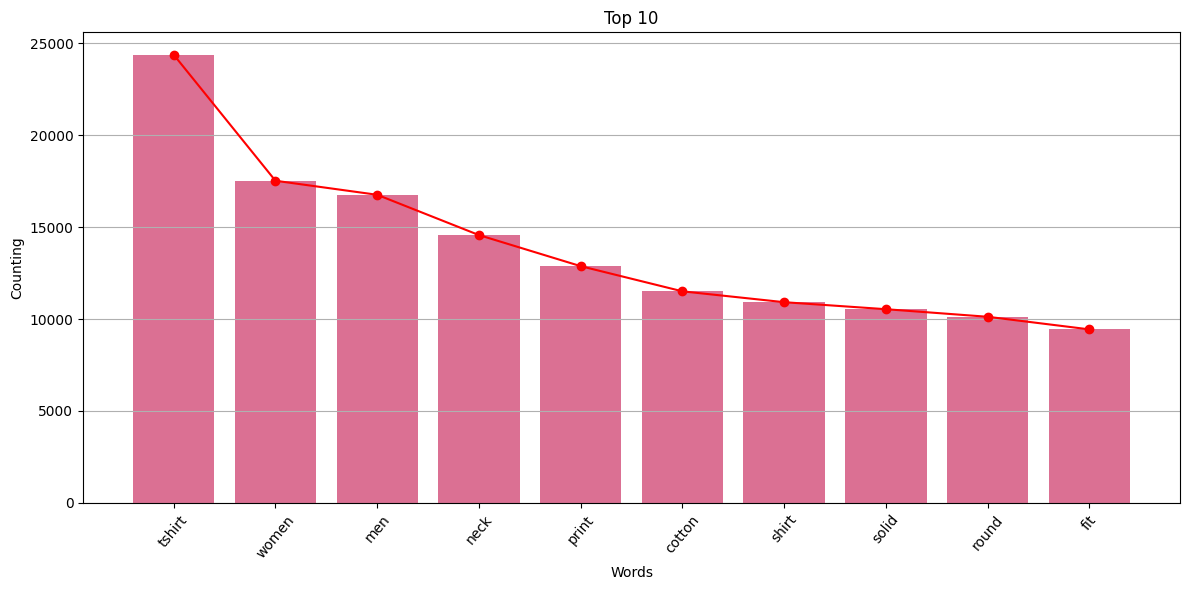

In [ ]:
word_ocurrences = word_count(fashion_df_processed, ["title", "description"])
plot_top_10(word_ocurrences, "Words in the Title and Description of the Products", "Words", "Counting", "palevioletred")

#### 2.2. Average Sequence Length and Vocabulary Size

In [ ]:
# Function to compute the average length of the text in a particular field
def avg_length(df, field):
  sum = 0
  for doc_id, product in df.iterrows(): # For each product registered
    sum += len(product[field]) # Sum the number of tokens
  return sum / df.shape[0]

In [ ]:
avg_title_length = avg_length(fashion_df_processed, "title")
avg_description_length = avg_length(fashion_df_processed, "description")
print(f'Average length of the title: {avg_title_length:.2f} words')
print(f'Average length of the description: {avg_description_length:.2f} words')

Average length of the title: 6.05 words
Average length of the description: 18.18 words


In [ ]:
print(f'Vocabulary size of the title and description of the products: {len(word_ocurrences)}')
print(f'Average number of unique words per product (considering only title and description): \
{len(word_ocurrences)/fashion_df_processed.shape[0]:.2f}')

Vocabulary size of the title and description of the products: 5778
Average number of unique words per title: 0.21
Average number of unique words per description: 0.21


#### 2.3. Ranking of Products (Subcategories)

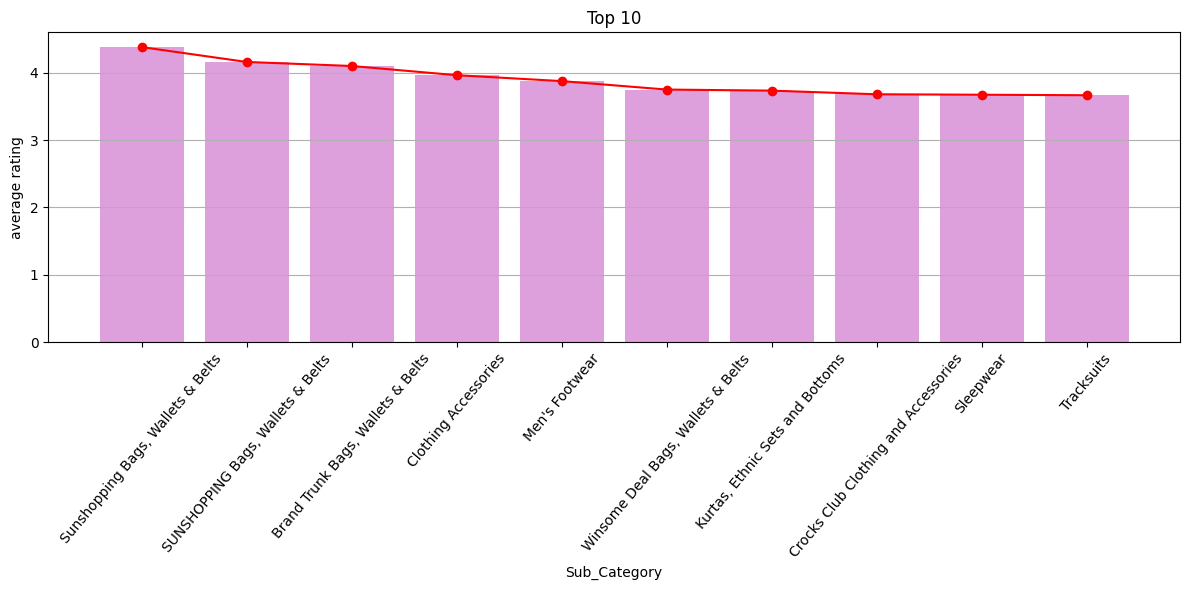

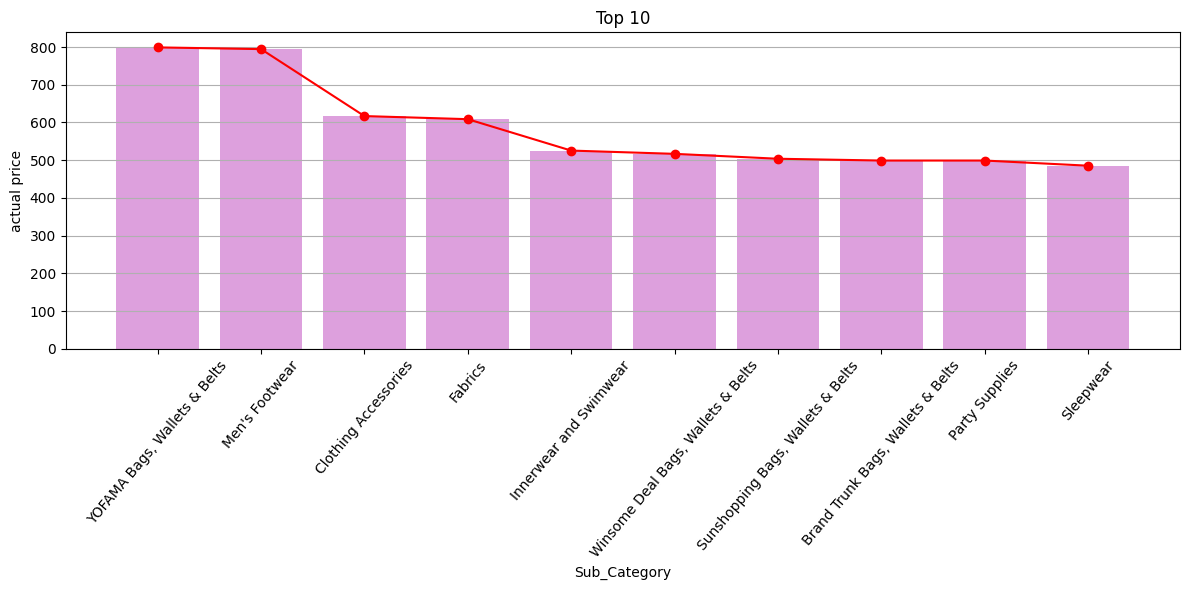

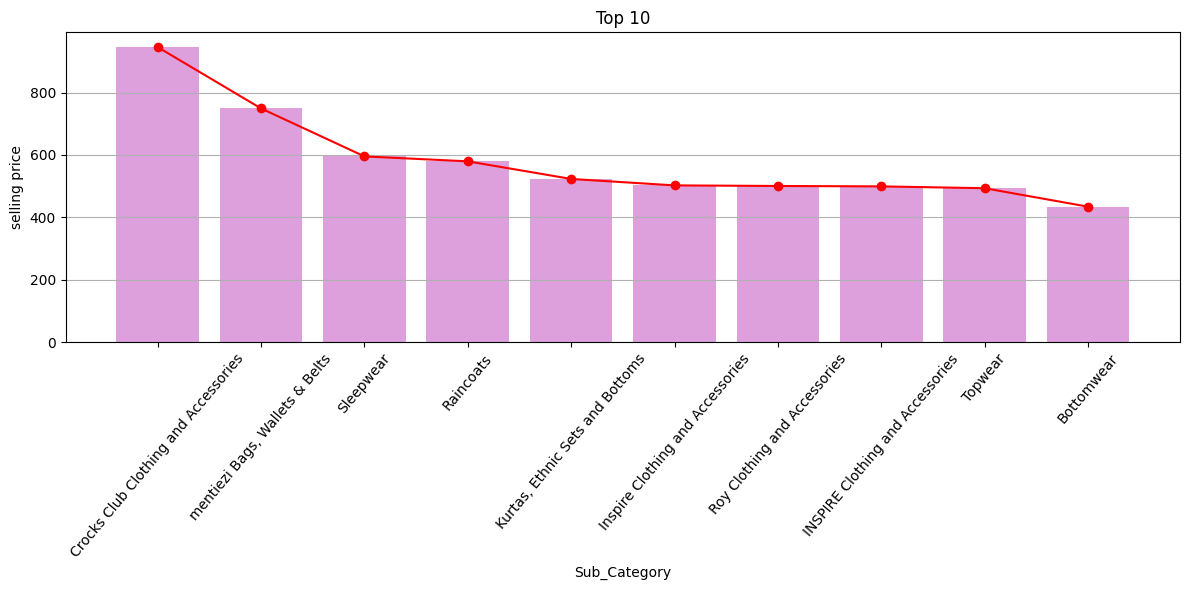

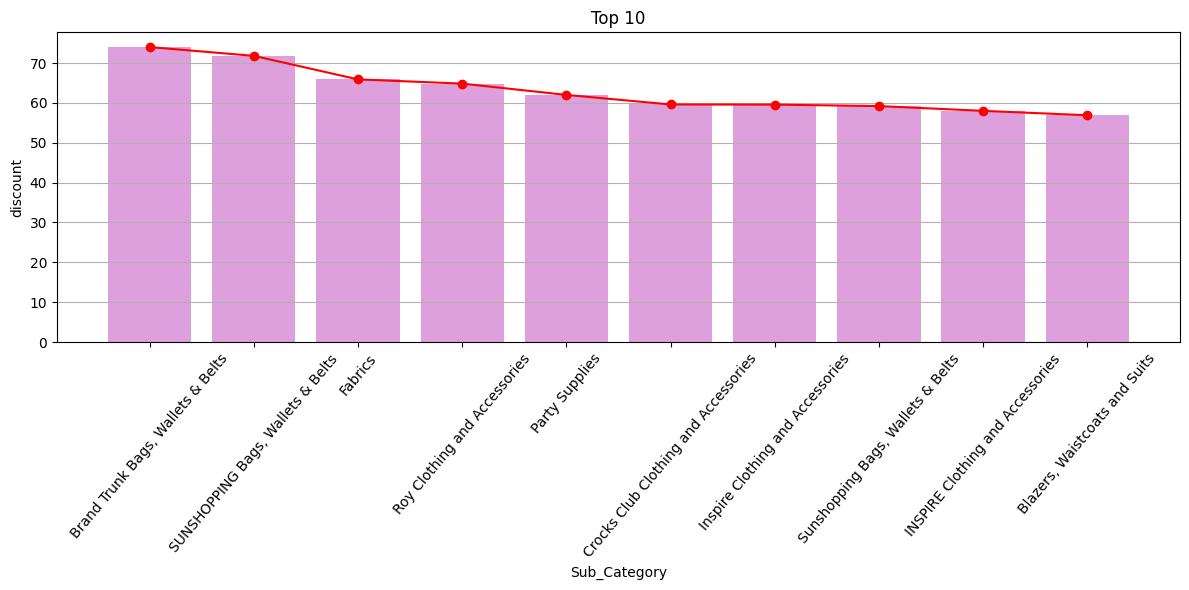

In [ ]:
fashion_df_2 = fashion_df.copy()

# Process "average rating" to do the ranking of best rated products
fashion_df_2 = fashion_df_2[~(fashion_df_2["average_rating"] == "")]
fashion_df_2["average_rating"] = fashion_df_2["average_rating"].dropna().astype(float)

# Process "actual price" and "selling price" to do the ranking of most expensive products
fashion_df_2 = fashion_df_2[~(fashion_df_2["actual_price"] == "")]
fashion_df_2["actual_price"] = fashion_df_2["actual_price"].str.replace(",", ".").astype(float)
fashion_df_2 = fashion_df_2[~(fashion_df_2["selling_price"] == "")]
fashion_df_2["selling_price"] = fashion_df_2["selling_price"].str.replace(",", ".").astype(float)

# Process "discount" to do the ranking of products with more discount
fashion_df_2 = fashion_df_2[~(fashion_df_2["discount"] == "")]
fashion_df_2["discount"] = fashion_df_2["discount"].str.replace("%", "") .str.replace("off", "").str.strip().astype(float)

# Show the plots
for column in ["average_rating", "actual_price", "selling_price", "discount"]:
  column_name = column.replace('_', ' ').title()
  top_ranking = fashion_df_2.groupby("sub_category")[column].mean().sort_values(ascending=False).to_dict()
  plot_top_10(top_ranking, f"Subcategories according to {column_name}", "Subcategory", column_name, "plum")

#### 2.4. Top Brands and Sellers

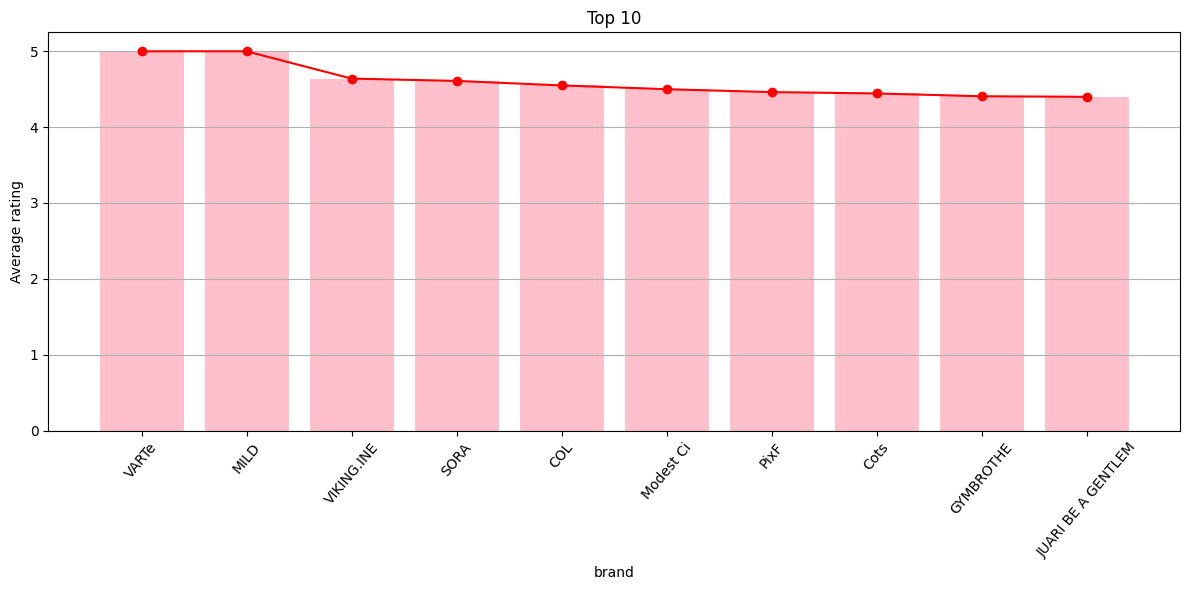

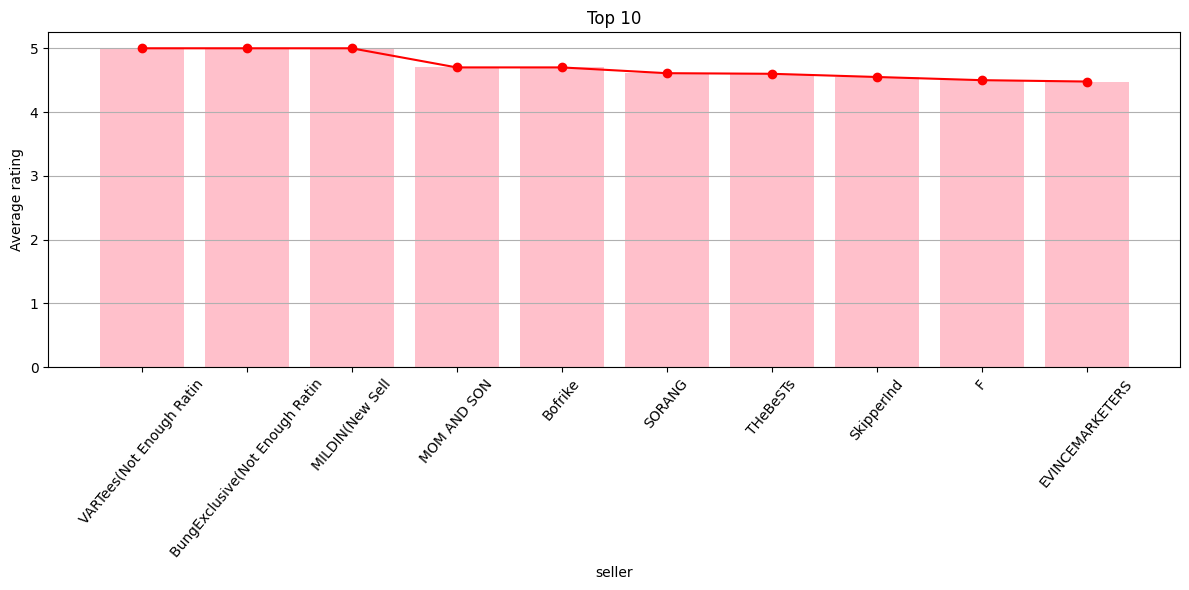

In [ ]:
fashion_df_2 = fashion_df.copy()

# Process "average rating" to do the ranking of best rated brands and sellers
fashion_df_2 = fashion_df_2[~(fashion_df_2["average_rating"] == "")]
fashion_df_2["average_rating"] = fashion_df_2["average_rating"].dropna().astype(float)

# Show the plots
for column in ["brand", "seller"]:
  column_name = column.replace('_', ' ').title()
  top_ranking = fashion_df_2.groupby(column)["average_rating"].mean().sort_values(ascending=False).to_dict()
  plot_top_10(top_ranking, f"{column_name}s", column_name, "Average Rating", "pink")

#### 2.5. Out-of-stock Distribution

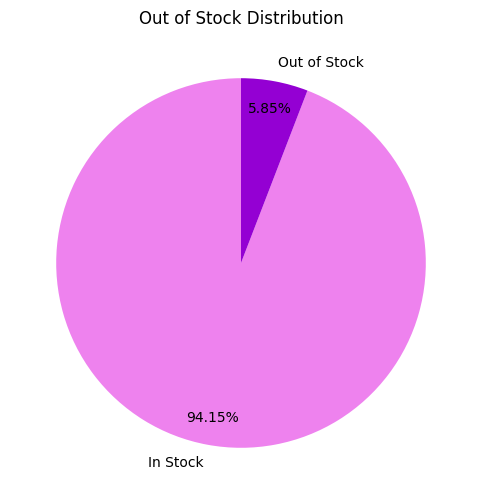

In [ ]:
# Count of in-stock vs out-of-stock
stock_counts = fashion_df["out_of_stock"].value_counts()

plt.figure(figsize=(6, 6))
plt.pie(stock_counts,  # Number of times of each value (True and False)
        labels=["In Stock", "Out of Stock"], # True = In Stock, False = Out of Stock
        autopct="%1.2f%%", # Format of the percentage (only 2 decimals)
        pctdistance=0.85, startangle=90, # Position of the numbers in the pie and the different wedges
        colors=["violet", "darkviolet"])

plt.title("Out-of-Stock Distribution")
plt.show()

#### 2.6. Word Cloud for Word Counting Distribution

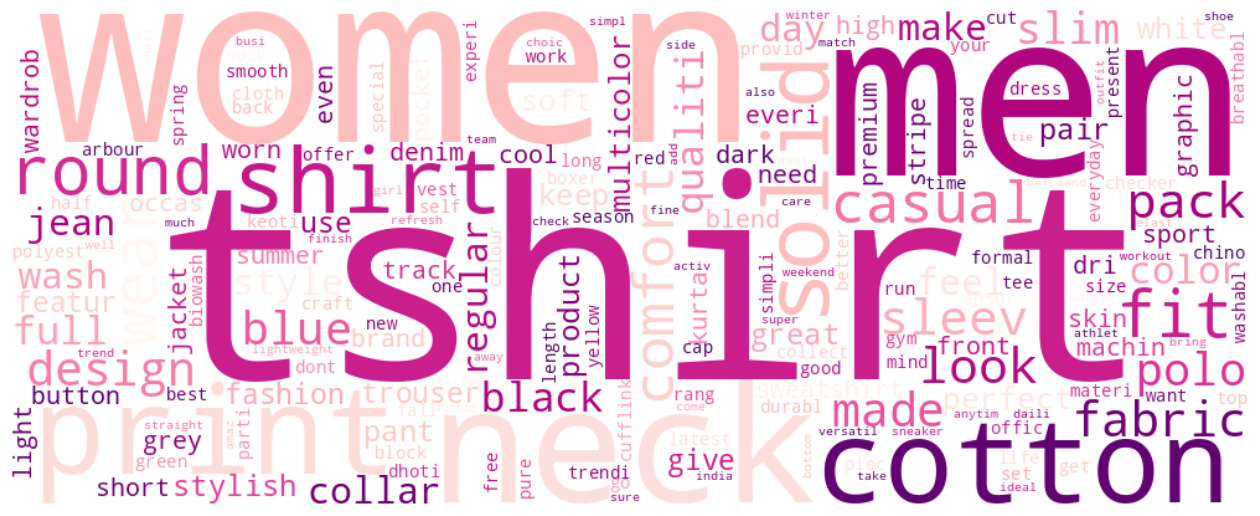

In [ ]:
# Generate word cloud based on the word counting distribution previously computed
fashion_wordcloud = WordCloud(width=1000, height=400, background_color='white', colormap= 'RdPu')
fashion_wordcloud.generate_from_frequencies(dict(word_ocurrences))

# Show the word cloud
f, ax = plt.subplots(figsize=(16, 8))
plt.imshow(fashion_wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

#### 2.7. Entity Recognition

In [ ]:
# Load the English NLP (Natural Language Processing) model
nlp = spacy.load("en_core_web_sm")

# Consider only the titles of the products
title_data = fashion_df["title"].dropna().unique()
titles = " ".join(title_data)

# Process all titles as one unique text
doc = nlp(titles)
entities = [(ent.text, ent.label_) for ent in doc.ents]

# Store results as a dataframe for better visualization
entities_df = pd.DataFrame(entities, columns=["entity", "label"])
entities_df.head(10)

,entity,label
0,Solid Women,PERSON
1,-Lite Satin Tie & Cufflink,ORG
2,Beige,PERSON
3,Brown,PERSON
4,Brown,PERSON
5,Brown Sweater,PERSON
6,Black Sweater Solid Men Raincoat Self Design M...,ORG
7,2,CARDINAL
8,Solid Men Polo Neck Red,PERSON
9,Grey T-Shirt (Pack of 2,ORG


## **Part 2: Indexing and Evaluation**

### **1. Indexing**

#### 1.1. Index Function

In [ ]:
def create_index_fashion_fields(fashion_df):
    """
    Implement the inverted index

    Argument:
    fashion_df -- collection of registered articles

    Returns:
    index - the inverted index (implemented through a Python dictionary) containing terms as keys and the corresponding
    list of documents where these keys appears in (and the field) as values.
    """
    index = defaultdict(list)
    title_index = {}

    for doc_id, row in fashion_df.iterrows():
        doc_id = row['pid']
        title_index[doc_id] = row.get('title', row.get('description', ''))

        # Temporary index for the current article/product
        current_page_index = {}

        # Go through each field of the dataset
        for field in ['category', 'sub_category', 'brand', 'product_details', 'seller']:

            for term in row[field]:
                try:
                    # If we already have the term in the dictionary, append the current field
                    if field not in current_page_index[term][1]:
                        current_page_index[term][1].append(field)
                except KeyError:
                    # If it is the first time that the term appears, add in the dictionary with the current field
                    current_page_index[term] = [doc_id, [field]]

        # Aggregate the current index to the global index
        for term, posting in current_page_index.items():
            index[term].append(posting)

    return index, title_index


In [ ]:
index, title_index = create_index_fashion_fields(fashion_df_processed)

print(index['cotton'])

[[0, ['product_details']], [1, ['product_details']], [2, ['product_details']], [3, ['product_details']], [4, ['product_details']], [5, ['product_details']], [6, ['product_details']], [7, ['product_details']], [8, ['product_details']], [9, ['product_details']], [10, ['product_details']], [11, ['product_details']], [12, ['product_details']], [13, ['product_details']], [14, ['product_details']], [15, ['product_details']], [16, ['product_details']], [17, ['product_details']], [18, ['product_details']], [19, ['product_details']], [20, ['product_details']], [21, ['product_details']], [22, ['product_details']], [23, ['product_details']], [24, ['product_details']], [25, ['product_details']], [26, ['product_details']], [27, ['product_details']], [28, ['product_details']], [29, ['product_details']], [30, ['product_details']], [31, ['product_details']], [32, ['product_details']], [33, ['product_details']], [34, ['product_details']], [173, ['product_details']], [174, ['product_details']], [175, ['

#### 1.2. Test Queries

In [ ]:
def search(index):
    """
    The output is the list of documents that contain any of the query terms.
    So, we will get the list of documents for each query term, and take the union of them.
    """
    query = input()
    query = build_terms(query) # so that stemed terms are matched in the index
    term_docs = [posting[0] for posting in index[query[0]]]
    docs = set(term_docs)
    for term in query[1:]:
        try:
            # Store in term_docs the ids of the docs that contain "term"
            term_docs = [posting[0] for posting in index[term]]
            # docs = docs U term_docs (union) --> to find the products with all the words in the query
            docs &= set(term_docs)
        except:
            # Term is not in index
            pass
    docs = list(docs)
    return docs

In [ ]:
# QUERY 1
print("Insert your query (i.e.: Comfort Women Dark Blue T-Shirt):\n")
docs = search(index)
top = 10

print("\n======================\nSample of {} results out of {} for the searched query:\n".format(min(top,len(docs)), len(docs)))
for d_id in docs[:top]:
    print("Register ID= {} - Product Title: {}".format(d_id, title_index[d_id]))

Insert your query (i.e.: Comfort Women Dark Blue T-Shirt):

Comfort Women Dark Blue T-Shirt

Sample of 3 results out of 3 for the searched query:

Register ID= 26960 - Product Title: ['solid', 'women', 'polo', 'neck', 'dark', 'blue', 'light', 'blue', 'pink', 'tshirt', 'pack']
Register ID= 26946 - Product Title: ['self', 'design', 'solid', 'women', 'polo', 'neck', 'dark', 'blue', 'light', 'blue', 'blue', 'tshirt', 'pack']
Register ID= 26942 - Product Title: ['self', 'design', 'solid', 'women', 'polo', 'neck', 'dark', 'blue', 'light', 'blue', 'green', 'tshirt', 'pack']


In [ ]:
# QUERY 2
print("Insert your query (i.e.: Green Stripe Men Cotton Polo):\n")
docs = search(index)
top = 10

print("\n======================\nSample of {} results out of {} for the searched query:\n".format(min(top,len(docs)), len(docs)))
for d_id in docs[:top]:
    print("Register ID= {} - Product Title: {}".format(d_id, title_index[d_id]))

Insert your query (i.e.: Green Stripe Men Cotton Polo):

Green Stripe Men Cotton Polo

Sample of 10 results out of 18 for the searched query:

page_id= 6784 - page_title: ['stripe', 'men', 'polo', 'neck', 'red', 'green', 'tshirt', 'pack']
page_id= 14203 - page_title: ['stripe', 'men', 'polo', 'neck', 'green', 'tshirt']
page_id= 14629 - page_title: ['stripe', 'men', 'polo', 'neck', 'green', 'blue', 'tshirt']
page_id= 27834 - page_title: ['stripe', 'men', 'polo', 'neck', 'green', 'tshirt']
page_id= 2793 - page_title: ['stripe', 'men', 'polo', 'neck', 'green', 'tshirt']
page_id= 6762 - page_title: ['stripe', 'men', 'polo', 'neck', 'multicolor', 'tshirt', 'pack']
page_id= 6731 - page_title: ['stripe', 'men', 'polo', 'neck', 'multicolor', 'tshirt', 'pack']
page_id= 6222 - page_title: ['stripe', 'men', 'polo', 'neck', 'green', 'tshirt']
page_id= 6447 - page_title: ['stripe', 'men', 'polo', 'neck', 'light', 'green', 'tshirt']
page_id= 6736 - page_title: ['stripe', 'men', 'polo', 'neck', 'mult

In [ ]:
# QUERY 3
print("Insert your query (i.e.: Solid Track Black Pants for Men):\n")
docs = search(index)
top = 10

print("\n======================\nSample of {} results out of {} for the searched query:\n".format(min(top,len(docs)), len(docs)))
for d_id in docs[:top]:
    print("Register ID= {} - Product Title: {}".format(d_id, title_index[d_id]))

Insert your query (i.e.: Solid Track Black Pants for Men):

Solid Track Black Pants for Men

Sample of 6 results out of 6 for the searched query:

page_id= 6139 - page_title: ['solid', 'men', 'blue', 'black', 'track', 'pant']
page_id= 6152 - page_title: ['solid', 'men', 'black', 'blue', 'track', 'pant']
page_id= 6639 - page_title: ['solid', 'men', 'hood', 'neck', 'black', 'tshirt']
page_id= 6160 - page_title: ['solid', 'men', 'maroon', 'black', 'track', 'pant']
page_id= 1556 - page_title: ['solid', 'men', 'black', 'track', 'pant']
page_id= 6171 - page_title: ['solid', 'men', 'black', 'track', 'pant']


In [ ]:
# QUERY 4
print("Insert your query (i.e.: Print stylish pyjama):\n")
docs = search(index)
top = 10

print("\n======================\nSample of {} results out of {} for the searched query:\n".format(min(top,len(docs)), len(docs)))
for d_id in docs[:top]:
    print("Register ID= {} - Product Title: {}".format(d_id, title_index[d_id]))

Insert your query (i.e.: Print stylish pyjama):

Print stylish pyjama

Sample of 0 results out of 0 for the searched query:



In [ ]:
# QUERY 5
print("Insert your query (i.e.: Cycling Clothes in Black):\n")
docs = search(index)
top = 10

print("\n======================\nSample of {} results out of {} for the searched query:\n".format(min(top,len(docs)), len(docs)))
for d_id in docs[:top]:
    print("Register ID= {} - Product Title: {}".format(d_id, title_index[d_id]))

Insert your query (i.e.: Cycling Clothes in Black):

Cycling Clothes in Black

Sample of 10 results out of 34 for the searched query:

page_id= 8966 - page_title: ['solid', 'men', 'round', 'neck', 'multicolor', 'tshirt', 'pack']
page_id= 8971 - page_title: ['solid', 'women', 'round', 'neck', 'multicolor', 'tshirt', 'pack']
page_id= 8976 - page_title: ['solid', 'men', 'round', 'neck', 'multicolor', 'tshirt', 'pack']
page_id= 8977 - page_title: ['solid', 'women', 'round', 'neck', 'multicolor', 'tshirt', 'pack']
page_id= 8978 - page_title: ['solid', 'men', 'round', 'neck', 'multicolor', 'tshirt', 'pack']
page_id= 8979 - page_title: ['solid', 'women', 'round', 'neck', 'multicolor', 'tshirt', 'pack']
page_id= 8981 - page_title: ['solid', 'women', 'round', 'neck', 'multicolor', 'tshirt', 'pack']
page_id= 8982 - page_title: ['solid', 'men', 'round', 'neck', 'multicolor', 'tshirt', 'pack']
page_id= 8983 - page_title: ['solid', 'men', 'round', 'neck', 'multicolor', 'tshirt', 'pack']
page_id= 89

#### 1.3. Ranking of Results

In [ ]:
def create_index_tfidf(dataset): # Create the index of the dataset
    num_registers = len(dataset)
    index = defaultdict(list)
    tf = defaultdict(dict)  # term -> {doc_id: tf}
    df = defaultdict(int)
    idf = defaultdict(float)
    title_index = {}

    for doc_id, row in dataset.iterrows():
        doc_id = row['pid']
        text = []
        for field in ['title', 'description', 'category', 'sub_category', 'brand', 'product_details', 'seller']:
            text.append(row[field])

        terms = build_terms(" ".join(text))
        title_index[doc_id] = row['title']

        current_page_index = {} # stores words and positions of CURRENT row
        for position, term in enumerate(terms):
            try:
                current_page_index[term][1].append(position)
            except KeyError:
                current_page_index[term] = [doc_id, [position]]

        # compute norm for term frequency
        norm = math.sqrt(sum(len(posting[1])**2 for posting in current_page_index.values()))
        if norm == 0: norm = 1.0

        # fill tf and df
        for term, posting in current_page_index.items():
            tf[term][doc_id] = len(posting[1]) / norm
            df[term] += 1

        # merge with main index
        for term, posting in current_page_index.items():
            index[term].append(posting) # main index stores words and positions from ALL rows

    # compute idf
    for term in df:
        idf[term] = math.log(num_registers / df[term])

    return index, tf, df, idf, title_index

def rank_documents(query_terms, candidate_docs, index, idf, tf, title_index):
    #gives you a score for each term in the query parameter and obtains a document score used to order the documents by ranking
    doc_scores = {}

    # Build query vector (tf-idf)
    q_tf = Counter(query_terms)
    q_norm = math.sqrt(sum(freq**2 for freq in q_tf.values()))
    if q_norm == 0: q_norm = 1.0
    q_vec = {term: (freq / q_norm) * idf.get(term, 0) for term, freq in q_tf.items()}

    for doc_id in candidate_docs:
        score = 0.0
        for term in query_terms:
            if doc_id in tf.get(term, {}):
                score += tf[term][doc_id] * idf.get(term, 0) * q_vec.get(term, 0)
        doc_scores[doc_id] = score

    ranked_docs = sorted(doc_scores, key=doc_scores.get, reverse=True)
    return ranked_docs, doc_scores

def search_tf_idf(query, index, tf, idf, title_index):
    #process a query, search for all the documents with the query terms, and calls ranking function to rank them
    query_terms = build_terms(query)
    docs = set()
    for term in query_terms:
        for posting in index.get(term, []):
            docs.add(posting[0])
    docs = list(docs)
    ranked_docs, doc_scores = rank_documents(query_terms, docs, index, idf, tf, title_index)
    return ranked_docs, doc_scores

# Apply to dataset
#index, tf, df, idf, title_index = create_index_tfidf(fashion_df_processed)


In [ ]:
index, tf, df, idf, title_index = create_index_tfidf(fashion_df)

# Interactive search
while True:
    query = input("\nEnter your search query (or type 'exit' to quit): ")
    if query.lower() == 'exit':
        print("Exiting search.")
        break

    # Search and rank documents
    ranked_docs, scores = search_tf_idf(query, index, tf, idf, title_index)

    if not ranked_docs:
        print("No results found for your query.")
        continue

    top = min(10, len(ranked_docs))
    docs = len(ranked_docs)

    print("\n======================")
    print("Sample of {} results out of {} for the searched query:\n".format(top, docs))

    # Display original titles ranked
    for rank, doc_id in enumerate(ranked_docs[:top], start=1):
        # original title from the dataset
        print(f"{rank}. {title_index[doc_id]}")



Enter your search query (or type 'exit' to quit): women full sleeve sweatshirt cotton

Sample of 10 results out of 25769 for the searched query:

1. Full Sleeve Solid Women Sweatshirt
2. Full Sleeve Solid Men Sweatshirt
3. Full Sleeve Solid Women Sweatshirt
4. Full Sleeve Solid Men Sweatshirt
5. Full Sleeve Solid Men Sweatshirt
6. Full Sleeve Color Block Men Sweatshirt
7. Full Sleeve Solid Women Sweatshirt
8. Full Sleeve Solid Women Sweatshirt
9. Full Sleeve Solid Men Sweatshirt
10. Full Sleeve Solid Men Sweatshirt

Enter your search query (or type 'exit' to quit): men slim jeans blue

Sample of 10 results out of 20034 for the searched query:

1. Regular Men Blue Jeans
2. Regular Men Blue Jeans
3. Regular Men Blue Jeans
4. Regular Men Dark Blue Jeans
5. Regular Women Blue Jeans
6. Regular Women Blue Jeans
7. Regular Women Blue Jeans
8. Stretchable Slim Men Blue Jeans  (Pack of 2)
9. Regular Women Blue Jeans
10. Regular Men Black Jeans

Enter your search query (or type 'exit' to quit):

KeyboardInterrupt: Interrupted by user

### **2. Evaluation**

#### 2.1. Evaluation Metrics

#### Precision@K

In [ ]:
def precision_at_k(y_true, y_score, k=10):
  #Of what I retrieved, how much is relevant?
    '''
    Parameters
    ----------
    y_true: Ground truth (true relevance labels).
    y_score: Predicted scores.
    k : number of doc to consider.

    Returns
    -------
    precision @k : float

    '''
    order = np.argsort(y_score)[::-1]
    y_true = np.take(y_true, order[:k])
    relevant = np.sum(y_true == 1)
    return relevant/k

#### Recall@K

In [ ]:
def recall_at_k(y_true, y_score, k=10):
  #Of what was relevant, how much did I retrieve?
    '''
    Parameters
    ----------
    y_true: Ground truth (true relevance labels).
    y_score: Predicted scores.
    k : number of doc to consider.

    Returns
    -------
    recall @k : float

    '''
    total_relevant = 0
    for val in y_true:
        if val == 1:
            total_relevant += 1

    if total_relevant == 0:
        return 0
    order = np.argsort(y_score)[::-1]
    y_true = np.take(y_true, order[:k])
    relevant = np.sum(y_true == 1)

    return relevant/total_relevant

#### Average Precision@K

In [ ]:
def avg_precision_at_k(y_true, y_score, k=10):
  #How well the relevant documents are distributed among the top-k results.
    """
    Parameters
    ----------
    y_true: Ground truth (true relevance labels).
    y_score: Predicted scores.
    k : number of doc to consider.

    Returns
    -------
    average precision @k : float
    """

    order = np.argsort(y_score)[::-1]  # get the list of indexes of the predicted score sorted in descending order.

    prec_at_i = 0
    prec_at_i_list = []
    number_of_relevant = 0
    number_to_iterate = min(k, len(order))

    for i in range(number_to_iterate):
        if y_true[order[i]] == 1:
            number_of_relevant += 1
            prec_at_i = number_of_relevant / (i + 1)
            prec_at_i_list.append(prec_at_i)

    if number_of_relevant == 0:
        return 0
    else:
      return np.sum(prec_at_i_list) / number_of_relevant

#### F1-Score@K

In [ ]:
def f1_at_k(y_true, y_score, k=10):
  #Harmonic mean of precision and recall. How good your ranking is for one query
  #F1=2×[(PrecisionxRecall)/(Precision+Recall)​]
  recall_at_k_result = recall_at_k(y_true, y_score, k)
  precision_at_k_result = precision_at_k(y_true, y_score, k)

  sum = recall_at_k_result + precision_at_k_result
  if sum == 0:
    return 0
  return 2 * (recall_at_k_result * precision_at_k_result) / sum

#### Mean Average Precision (MAP)

In [ ]:
def map_at_k(search_res, k=10):
  #How good your system is overall across many queries
    '''
    Parameters
    ----------
    search_res: search results dataset containing:
        q_id: query id.
        doc_id: document id.
        predicted_relevance: relevance predicted through LightGBM.
        y_true: actual score of the document for the query (ground truth).

    Returns
    -------
    mean average precision @k : float
    '''
    avp = []
    for q in search_res["query_id"].unique():  #loop over all query id
        curr_data = search_res[search_res["query_id"] == q]  # select data for current query
        avp.append(avg_precision_at_k(np.array(curr_data["labels"]), np.array(curr_data["score"]),
                                      k))  #append average precision for current query
    return np.sum(avp) / len(avp)  # return mean average precision

#### Mean Reciprocal Rank (MRR)

In [ ]:
def rr_at_k(y_true, y_score, k=10):
  #How high the first relevant item appears in the ranked list — averaged across many queries
  #MRR=1/Q​∑Q1/​(rq)​
    """
    Parameters
    ----------
    y_true: Ground truth (true relevance labels).
    y_score: Predicted scores.
    k : number of doc to consider.

    Returns
    -------
    Reciprocal Rank for current query
    """

    order = np.argsort(y_score)[::-1] # get the list of indexes of the predicted score sorted in descending order.
    y_true = np.take(y_true, order[:k]) # sort the actual relevance label of the documents based on predicted score(hint: np.take) and take first k.
    if sum(y_true==1) == 0: # if there are not relevant doument return 0
        return 0
    return 1 / (np.argmax(y_true == 1) + 1) # hint: to get the position of the first relevant document use "np.argmax"



In [ ]:
def mrr_at_k(search_res, k=10):
  rr_scores = []
  for q in search_res['query_id'].unique():
      query_data = search_res[search_res['query_id'] == q]
      labels = np.array(query_data["labels"])
      scores = np.array(query_data["score"])

      rr_scores.append(rr_at_k(labels, scores, k))

  return np.sum(rr_scores) / len(rr_scores)

#### Normalized Discounted Cumulative Gain (NDCG)

In [ ]:
#How good the ranking order is, taking into account both relevance and position of results in the ranked list

def dcg_at_k(y_true, y_score, k=10):
    order = np.argsort(y_score)[::-1]  # get the list of indexes of the predicted score sorted in descending order.
    y_true = np.take(y_true, order[
                             :k])  # sort the actual relevance label of the documents based on predicted score(hint: np.take) and take first k.
    gain = 2 ** y_true - 1  # Compute gain (use formula 7 above)
    discounts = np.log2(np.arange(len(y_true)) + 2)  # Compute denominator
    return np.sum(gain / discounts)  #return dcg@k


def ndcg_at_k(y_true, y_score, k=10):
    dcg_max = dcg_at_k(y_true, y_true, k)
    if not dcg_max:
        return 0
    return np.round(dcg_at_k(y_true, y_score, k) / dcg_max, 4)

#### 2.2. Evaluation on Validation Data

In [ ]:
# Queries
queries = {1: "women full sleeve sweatshirt cotton", 2: "men slim jeans blue"}

results = list()
for query_id, query_text in queries.items(): #for each query
    ranked_docs, doc_scores = search_tf_idf(query_text, index, tf, idf, title_index) #we compute the tfidf scores
    for doc_id, row in val_df[val_df['query_id'] == query_id].iterrows():
        score = doc_scores.get(doc_id, 0)
        results.append([doc_id, query_id, score, row['labels']])

final_df = pd.DataFrame(results, columns=['doc_id', 'query_id', 'score', 'labels'])

In [ ]:
k = [4, 8, 12, 16, 20]  # poner los valores que queramos de k
for k_j in k:
  mrr_list = list()
  ndcg_list = list()
  print("\n======================")
  for query_id, query_text in queries.items():
    print("\nValidation Metrics of query {}: '{}', for k = {} :".format(query_id, query_text, k_j))

    result = final_df[final_df["query_id"] == query_id]
    labels = result["labels"].to_list()
    scores = result["score"].to_list()

    print(f"Precision@{k_j}: {precision_at_k(labels, scores, k_j):.3f}")
    print(f"Recall@{k_j}: {recall_at_k(labels, scores, k_j):.3f}")
    print(f"Average Precision@{k_j}: {avg_precision_at_k(labels, scores, k_j):.3f}")
    print(f"F1-Score@{k_j}: {f1_at_k(labels, scores, k_j):.3f}")
    print(f"Normalized Discounted Cumulative Gain@{k_j}: {ndcg_at_k(labels, scores, k_j):.3f}")
    mrr_list.append(rr_at_k(labels, scores, k_j))

  print("\nValidation Metrics of both queries:")
  print(f"Mean Average Precision@{k_j}: {map_at_k(final_df, k_j):.3f}")
  print(f"Mean Reciprocal Rank@{k_j}: {np.mean(mrr_list):.3f}")



Validation Metrics of query 1: 'women full sleeve sweatshirt cotton', for k = 4 :
Precision@4: 0.750
Recall@4: 0.231
Average Precision@4: 0.639
F1-Score@4: 0.353
Normalized Discounted Cumulative Gain@4: 0.610

Validation Metrics of query 2: 'men slim jeans blue', for k = 4 :
Precision@4: 0.250
Recall@4: 0.100
Average Precision@4: 0.250
F1-Score@4: 0.143
Normalized Discounted Cumulative Gain@4: 0.168

Validation Metrics of both queries:
Mean Average Precision@4: 0.444
Mean Reciprocal Rank@4: 0.375


Validation Metrics of query 1: 'women full sleeve sweatshirt cotton', for k = 8 :
Precision@8: 0.625
Recall@8: 0.385
Average Precision@8: 0.710
F1-Score@8: 0.476
Normalized Discounted Cumulative Gain@8: 0.583

Validation Metrics of query 2: 'men slim jeans blue', for k = 8 :
Precision@8: 0.500
Recall@8: 0.400
Average Precision@8: 0.430
F1-Score@8: 0.444
Normalized Discounted Cumulative Gain@8: 0.381

Validation Metrics of both queries:
Mean Average Precision@8: 0.570
Mean Reciprocal Rank@8

#### 2.3 Evaluation on our Queries

In [ ]:
# Queries
queries = {1: "Comfort Women Dark Blue T-Shirt",
           2: "Green Stripe Men Cotton Polo",
           3: "Solid Track Black Pants for Men",
           4: "Print stylish pyjama",
           5: "Cycling Clothes in Black"}



results = list()
for query_id, query_text in queries.items(): #for each query
    ranked_docs, doc_scores = search_tf_idf(query_text, index, tf, idf, title_index) #we compute the tfidf scores
    for doc_id, row in val_df[val_df['query_id'] == query_id].iterrows():
        score = doc_scores.get(doc_id, 0)
        results.append([doc_id, query_id, score, row['labels']])

final_df = pd.DataFrame(results, columns=['doc_id', 'query_id', 'score', 'labels'])

In [ ]:
new_validation_df = pd.DataFrame()
for query_id, query_text in queries.items():
   current_validation_df = fashion_df[['title','pid']]
   current_validation_df['query_id']= pd.Series([query_id]*current_validation_df.shape[0])

   ranked_docs, doc_scores = search_tf_idf(query_text, index, tf, idf, title_index)
   mask = current_validation_df['pid'].isin(ranked_docs)
   current_validation_df.loc[mask,'labels'] = 1
   current_validation_df.loc[~mask,'labels'] = 0
   current_validation_df['score'] = current_validation_df['pid'].apply(lambda x: doc_scores.get(x, 0))

   new_validation_df = pd.concat([new_validation_df, current_validation_df])

/tmp/ipython-input-2251303220.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  current_validation_df['query_id']= pd.Series([query_id]*current_validation_df.shape[0])
/tmp/ipython-input-2251303220.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  current_validation_df.loc[mask,'labels'] = 1
/tmp/ipython-input-2251303220.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docume

In [ ]:
new_validation_df

,title,pid,query_id,labels,score
0,Solid Women Multicolor Track Pants,TKPFCZ9EA7H5FYZH,1,1.0,0.029556
1,Solid Men Blue Track Pants,TKPFCZ9EJZV2UVRZ,1,1.0,0.319295
2,Solid Men Multicolor Track Pants,TKPFCZ9EHFCY5Z4Y,1,0.0,0.000000
3,Solid Women Multicolor Track Pants,TKPFCZ9ESZZ7YWEF,1,1.0,0.029556
4,"Solid Women Brown, Grey Track Pants",TKPFCZ9EVXKBSUD7,1,1.0,0.028359
...,...,...,...,...,...
28075,Sleeveless Solid Men Jacket,JCKFYPM35WMMTAEN,5,1.0,0.000014
28076,Printed Men Blue Regular Shorts,SRTFV8S7DCEWAQVH,5,1.0,0.000013
28077,Checkered Single Breasted Casual Women Full Sl...,BZRFNAH7NWUB6F5E,5,1.0,0.000012
28078,Full Sleeve Solid Men Casual Jacket,JCKFWZZM6V7RS5EA,5,1.0,0.000012


In [ ]:
k = [1000, 3000, 5000, 10000, 20000]  # poner los valores que queramos de k
for k_j in k:
  mrr_list = list()
  ndcg_list = list()
  print("\n======================")
  for query_id, query_text in queries.items():
    print("\nValidation Metrics of query {}: '{}', for k = {} :".format(query_id, query_text, k_j))

    result = new_validation_df[new_validation_df["query_id"] == query_id]
    labels = result["labels"].to_list()
    scores = result["score"].to_list()

    print(f"Precision@{k_j}: {precision_at_k(labels, scores, k_j):.3f}")
    print(f"Recall@{k_j}: {recall_at_k(labels, scores, k_j):.3f}")
    print(f"Average Precision@{k_j}: {avg_precision_at_k(labels, scores, k_j):.3f}")
    print(f"F1-Score@{k_j}: {f1_at_k(labels, scores, k_j):.3f}")
    print(f"Normalized Discounted Cumulative Gain@{k_j}: {ndcg_at_k(labels, scores, k_j):.3f}")
    mrr_list.append(rr_at_k(labels, scores, k_j))

  print("\nValidation Metrics of both queries:")
  print(f"Mean Average Precision@{k_j}: {map_at_k(new_validation_df, k_j):.3f}")
  print(f"Mean Reciprocal Rank@{k_j}: {np.mean(mrr_list):.3f}")



Validation Metrics of query 1: 'Comfort Women Dark Blue T-Shirt', for k = 1000 :
Precision@1000: 1.000
Recall@1000: 0.043
Average Precision@1000: 1.000
F1-Score@1000: 0.082
Normalized Discounted Cumulative Gain@1000: 1.000

Validation Metrics of query 2: 'Green Stripe Men Cotton Polo', for k = 1000 :
Precision@1000: 1.000
Recall@1000: 0.040
Average Precision@1000: 1.000
F1-Score@1000: 0.078
Normalized Discounted Cumulative Gain@1000: 1.000

Validation Metrics of query 3: 'Solid Track Black Pants for Men', for k = 1000 :
Precision@1000: 1.000
Recall@1000: 0.045
Average Precision@1000: 1.000
F1-Score@1000: 0.087
Normalized Discounted Cumulative Gain@1000: 1.000

Validation Metrics of query 4: 'Print stylish pyjama', for k = 1000 :
Precision@1000: 1.000
Recall@1000: 0.088
Average Precision@1000: 1.000
F1-Score@1000: 0.162
Normalized Discounted Cumulative Gain@1000: 1.000

Validation Metrics of query 5: 'Cycling Clothes in Black', for k = 1000 :
Precision@1000: 1.000
Recall@1000: 0.036
A